In [1]:
import math
from radis import get_version
print(get_version())

conditions = {
    'wavenum_min':500,             # cm-1
    'wavenum_max':10000,           # cm-1
    'molecule':'OH',
    'isotope':'1',
    'pressure':1.01325,            # bar 
    'Tgas':300,
    'mole_fraction':0.1,
    'path_length':1,
    'cutoff':1e-27,
    'verbose':3,
    'databank':'hitemp'
    }


0.9.28


## Optimization = 'simple'


In [2]:
from radis import calc_spectrum
import math
s1 = calc_spectrum(**conditions,
                  optimization='simple', 
                  )
s1.name = 'LDM, simple ({0:.1f}s)'.format(s1.conditions['calculation_time'])


Using existing database HITEMP-OH
Generated dataframe from /home/pipebomb/.radisdb/OH-13_HITEMP2020.h5 in 0.15s (24164 rows, 19 columns, 14.06 MB)
The following columns had the `object` format and were removed: ['globu', 'globl', 'locu', 'locl', 'ierr', 'iref', 'lmix']
... Fetching molecular parameters for all transitions
... Fetched molecular params in 0.00s
HAPI version: 1.1.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.

/home/pipebomb/Desktop/radis/radis/misc/warning.py:302: MissingSelfBroadeningWarning: Self-broadening temperature coefficient Tdpsel not given in database: used Tdpair instead
  warnings.warn(WarningType(message))


... Precomputed DLM lineshapes (92) in 2.9s
... Initialized vectors in 0.0s
... Get closest matching line & fraction in 0.0s
... Distribute lines over DLM 0.0s
... Convolve and sum on spectral range 68.8s
Calculated line broadening in 71.72s
Calculated other spectral quantities in 0.05s
Spectrum calculated in 71.80s (before object generation)
Generated Spectrum object in 0.04s
Spectrum calculated in 71.84s


## Optimization = None

In [3]:
s2 = calc_spectrum(**conditions,
                   optimization=None,
                  )
s2.name = 'None ({0:.1f}s)'.format(s2.conditions['calculation_time'])


Using existing database HITEMP-OH
Generated dataframe from /home/pipebomb/.radisdb/OH-13_HITEMP2020.h5 in 0.14s (24164 rows, 19 columns, 14.06 MB)
The following columns had the `object` format and were removed: ['globu', 'globl', 'locu', 'locl', 'ierr', 'iref', 'lmix']
... Fetching molecular parameters for all transitions
... Fetched molecular params in 0.00s
HAPI version: 1.1.2.0
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K
   isotope              1
   mole_fraction        0.1
   molecule             OH
   path_length          1 cm
   pressure_mbar        1013.25 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution     boltzmann
   wavenum_max          10000.0000 cm-1
   wavenum_min          500.0000 cm-1
Computation Parameters
----------------------------------------
   Tref             

/home/pipebomb/Desktop/radis/radis/misc/warning.py:302: MissingSelfBroadeningWarning: Self-broadening temperature coefficient Tdpsel not given in database: used Tdpair instead
  warnings.warn(WarningType(message))


## Comparison of performance and accuracy of both methods

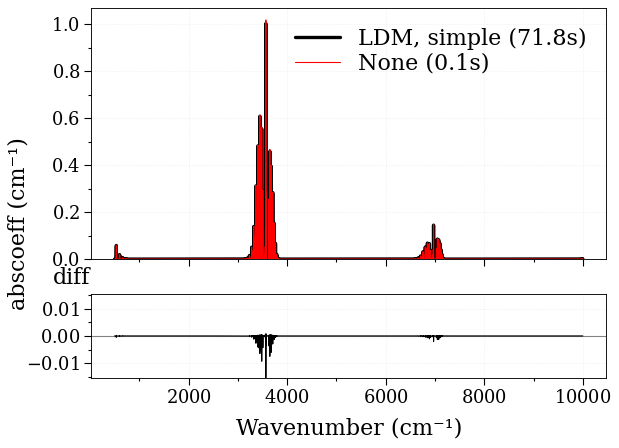

(<Figure size 640x480 with 2 Axes>,
 [<AxesSubplot:>, <AxesSubplot:xlabel='Wavenumber (cm⁻¹)'>])

In [4]:
from radis import plot_diff
plot_diff(s1, s2, 'abscoeff')

### R = broadening_cutoff  / wstep * N_lines / log(spectral range / wstep)

### Loading Scaling Parameter

In [5]:
# Wavenumber Range
spectral_range = s1.conditions['wavenum_max_calc'] - s1.conditions['wavenum_min_calc']
# Grid resolution
wstep = s1.conditions['wstep']
# Number of points on the spectral grid
points = spectral_range/wstep
# Broadening cutoff to calculate convolution over
broadening_cutoff = s2.conditions['broadening_max_width']
# Number of lines
n_lines = s2.conditions['total_lines']


DLM scales as for 'fft' broadening method - **spectral range / wstep * log(spectral range / wstep)**

In [6]:
DLM_Scale = points * math.log(points,10)
print(DLM_Scale)

5685249.671602007


Legacy Method Scales as - **broadening_cutoff * spectral range / wstep^2 (convolution) * N_lines**

In [7]:
Legacy_Scale = broadening_cutoff * spectral_range/math.pow(wstep,2) * n_lines
print(Legacy_Scale)

22979963999979.375


## **R formula**

In [8]:
R = Legacy_Scale/DLM_Scale
print(R)

4042032.509981925


## Inference
As we can see, R = 4e6 and already we are seeing that Legacy method is outperforming LDM by a big margin (**around 700 times faster for the given conditions**). We can infer from this for a value of R = 4e6, we are in Legacy territory, therefore we can safely assume that the critical value at which we want to switch between legacy and LDM will be larger than current R value 